In [8]:
import os
import sys
import logging
import mlflow
import joblib
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from minio import Minio

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDRegressor, Ridge, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor


from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# settings
MINIO_HOST = os.environ.get('MINIO_HOST', '')
MINIO_ACCESS_KEY = os.environ.get('MINIO_ACCESS_KEY', '')
MINIO_SECRET_KEY = os.environ.get('MINIO_SECRET_KEY', '')

os.environ['MLFLOW_TRACKING_URI'] = ""
os.environ['MLFLOW_S3_ENDPOINT_URL'] = ""
os.environ['AWS_ACCESS_KEY_ID'] = ''
os.environ['AWS_SECRET_ACCESS_KEY'] = ''

CATEGORICAL_COLUMNS = [
            'DG_1_condition','DG_2_condition',
            'DG_4_condition','ship_inclination'
        ]
DATE_COL = ['measurement_time']
NUMERICAL_COLUMNS = [
             'cyl_chargeair_press', 'AE_FO_inlet_flow',
             'draught_aft_side', 'AE_FO_inlet_Temp',
             'engine_speed','DG_1_power',
             'DG_2_power','DG_4_power',
             'CAC_CW_HT_pressure', 'CAC_in_Low_Temperature_CW_temp',
             'propeller_shaft_output', 'propeller_shaft_rpm',
             'propeller_shaft_thrust', 'cyl_chargeair_temp',
             'ship_speed_actual', 'Ship_SpeedLOG', 
             'cyl_exh_gas_temp_mean','torque',
             'AE_FO_outlet_flow', 'AE_FO_outlet_Temp',
             'Eng_in_HTCW_press', 'Eng_in_Jacket_HTCW_temp',
             'Eng_out_Jacket_HTCW_temp', 'Eng_Relative_load',
             'FO_Rack_position', 'FO_inlet_press',
             'fueloil_inlet_temperature', 'ME_FO_inlet_flow',
             'ME_FO_outlet_Temp', 'ME_FO_outlet_flow',
             'LO_Filter_P', 'LO_filter_in_press',
             'LO_in_press', 'LO_in_temp',
             'LO_out_temp_TC', 'LO_cooler_CW_out_temp'
        ]

FOR_NORMALIZATION_COLS = NUMERICAL_COLUMNS
MONITORING_COL_NAME = 'ME_FO_consumption'
MONITORING_COL = [MONITORING_COL_NAME]

ABORT_COLS = ['ME_FO_consumption', 'measurement_time']


logging.basicConfig(stream=sys.stdout, level=logging.INFO,
                    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s")
log = logging.getLogger(__name__)

In [3]:
class LoadDataSet(object):
    def __init__(self):
        self.random_state = 42
        self.bucket = 'uploads'
        self.directory = 'data'


        self.columns_used = DATE_COL + NUMERICAL_COLUMNS + CATEGORICAL_COLUMNS + MONITORING_COL
    
    def load_dataset_(self, ship_id):
        client = Minio(
            MINIO_HOST,
            access_key=MINIO_ACCESS_KEY,
            secret_key=MINIO_SECRET_KEY,
            secure=False
        )
        data_path = f'{self.directory}/{ship_id}.csv'
        obj = client.get_object(self.bucket, data_path)
        df = pd.read_csv(obj, parse_dates=['measurement_time'], usecols=self.columns_used)
        return df

In [71]:
class ME_FuelConsumptionPredictBase(object):
    def __init__(self):
        self.client = mlflow.tracking.MlflowClient() 
    
    def _load_artifacts(self,
                        run_id,
                        model_name
                   ):
        local_dir = "artifact_downloads"
        if not os.path.exists(local_dir):
            os.mkdir(local_dir)
        model_uri = f"runs:/{run_id}/{model_name}"
        loaded_model = mlflow.sklearn.load_model(model_uri)
        if 'feature_scaler.pkl' not in os.listdir('artifact_downloads'):
            self.client.download_artifacts(run_id=run_id, path='', dst_path=local_dir)
        if 'y_scaler.pkl' not in os.listdir('artifact_downloads'):
            self.client.download_artifacts(run_id=run_id, path='', dst_path=local_dir)
        y_scaler = joblib.load('artifact_downloads/y_scaler.pkl')
        feature_scaler = joblib.load('artifact_downloads/feature_scaler.pkl')
        return loaded_model, feature_scaler, y_scaler
    
    def _pre_process(self,
                     df,
                     feature_scaler,
                     y_scaler
                    ):
        df = df.dropna()        
        df[FOR_NORMALIZATION_COLS] = feature_scaler.transform(
            df[FOR_NORMALIZATION_COLS]
        )

        df[MONITORING_COL] = y_scaler.transform(
            df[MONITORING_COL]
        )
        abort_cols = ABORT_COLS
        Y = df[MONITORING_COL]
        X = df[[column for column in df.columns if column not in ABORT_COLS]]
        return X, Y
    
    def _visualize_results(self, actual, predicted):
        fig, axs = plt.subplots(2 ,figsize=(5, 10))
        fig.suptitle('Actual ME Fuel Consumption vs Predicted ME Fuel Consumption')
        fig.subplots_adjust(hspace=0.3)
        p1 = max(max(predicted), max(actual))
        p2 = min(min(predicted), min(actual))

        axs[0].scatter(actual, predicted, c='crimson')


        axs[0].plot([p1, p2], [p1, p2], 'b-')
        axs[0].set_xlabel('True Values')
        axs[0].set_ylabel('Predictions')
        axs[0].axis('equal')
        axs[0].set_title('Regression Scatterplot')

        axs[1].plot(Y)
        axs[1].set_title('Actual vs Predicted')
        axs[1].legend(['ME_FO_consumption', 'predictions'])
        return fig

In [72]:
run_id = '8f61bbe1ffcb4d89b003ff3a12d616e9'
model_name = 'gradient_boosting_regressor'
obj = ME_FuelConsumptionPredictBase()
loaded_model, feature_scaler, y_scaler = obj._load_artifacts(run_id=run_id, model_name=model_name)

In [6]:
ship_id = 'ship_1'
load_obj = LoadDataSet()
vessel_data = load_obj.load_dataset_(ship_id=ship_id)

In [7]:
# testing phase
vessel_sample = vessel_data.head(200)
X, Y = obj._pre_process(df=vessel_sample, feature_scaler=feature_scaler, y_scaler=y_scaler)
predictions = pd.Series(loaded_model.predict(X))
Y['predictions'] = predictions

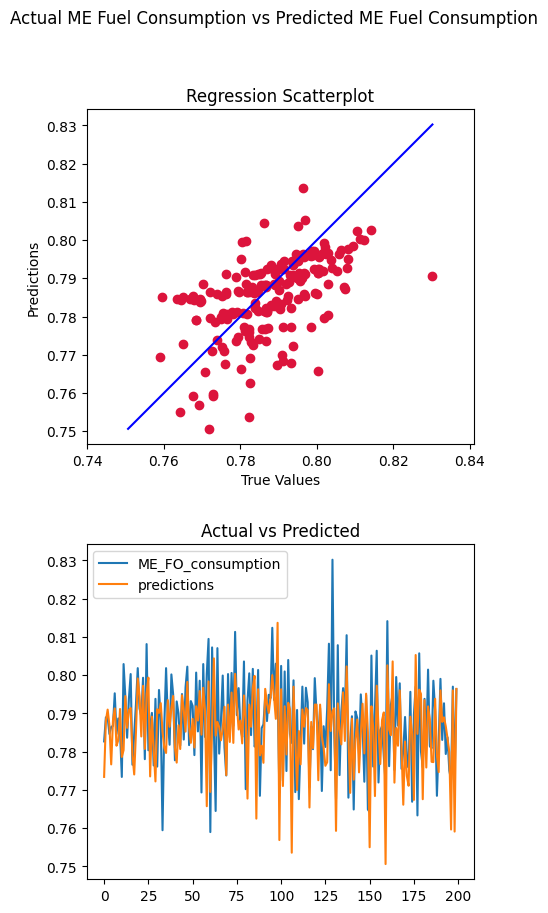

In [73]:
fig = obj._visualize_results(Y['ME_FO_consumption'], Y['predictions'])